# Analysis of movie budget relative to primary outcomes: Movie Ratings, Gross Revenue

Importing packages and reading in data

In [31]:
#importing necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
#file paths for importing data
#NOTE that some unzipped files are too large for the github repo and must be extracted locally before analysis can be performed
movie_budget_file_path = '~/Documents/Flatiron/phase_1/Movie_Studio_DATA/tn.movie_budgets.csv.gz'
microsoft_movie_studio_db_file_path = './../Movie_Studio_DATA/im.db'
msms_db_conn = sqlite3.connect(microsoft_movie_studio_db_file_path)

In [3]:
#reading in movie budget csv for outcome data
movie_budget_df = pd.read_csv(movie_budget_file_path)
#check to see if read properly
movie_budget_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [4]:
#execute SQL query to obtain a dataframe with movie names and avg ratings, filtered for original titles
avg_ratings_query = """
SELECT movie_basics.primary_title, movie_ratings.*
FROM movie_basics
INNER JOIN movie_ratings ON movie_basics.movie_id = movie_ratings.movie_id 
INNER JOIN movie_akas ON movie_ratings.movie_id = movie_akas.movie_id
WHERE is_original_title != 0.0
"""

microsoft_movie_studio_avg_ratings = pd.read_sql(avg_ratings_query, msms_db_conn)

#check query results
microsoft_movie_studio_avg_ratings

,primary_title,movie_id,averagerating,numvotes
0,Jurassic World,tt0369610,7.0,539338
1,John Carter,tt0401729,6.6,241792
2,Versailles Rediscovered - The Sun King's Vanis...,tt10010134,7.0,5
3,Alice in Wonderland,tt1014759,6.5,358813
4,From Paris with Love,tt1179034,6.5,107079
...,...,...,...,...
36890,Der Atem,tt9644084,5.2,5
36891,Homing,tt9657946,6.0,16
36892,Anderswo. Allein in Afrika,tt9723084,6.7,35
36893,Monkey King: The Volcano,tt9726638,6.0,6


Below are some descriptive methods used to determine what is necessary to clean this dataset for final analysis

In [5]:
microsoft_movie_studio_avg_ratings.describe()

,averagerating,numvotes
count,36895.000000,3.689500e+04
mean,6.173877,6.956449e+03
std,1.337955,4.252235e+04
min,1.000000,5.000000e+00
25%,5.400000,3.700000e+01
50%,6.300000,1.850000e+02
75%,7.100000,1.032000e+03
max,10.000000,1.841066e+06


In [6]:
movie_budget_df.describe()

,id
count,5782.000000
mean,50.372363
std,28.821076
min,1.000000
25%,25.000000
50%,50.000000
75%,75.000000
max,100.000000


In [7]:
microsoft_movie_studio_avg_ratings["primary_title"].value_counts()

Together                                     7
Paradise                                     7
Home                                         7
Brothers                                     6
Delirium                                     6
                                            ..
Ted Sieger's Molly Monster - Der Kinofilm    1
Man of Will                                  1
Ammani                                       1
Sound City                                   1
Cinzento e Negro                             1
Name: primary_title, Length: 35419, dtype: int64

Begin Data Cleaning:

In [8]:
#attempt to merge dataframes along movie titles. Inner merge will produce a dataframe that only includes movies for which a complete dataset is available.
movie_rating_budget_df = pd.merge(microsoft_movie_studio_avg_ratings, movie_budget_df, how='inner', left_on='primary_title', right_on='movie' )

In [9]:
movie_rating_budget_df 
#note the presence of a non-null-type null value in row 3 for gross sales. 
#These, and similar data, must be identified and dropped from the dataset after conversion to a numeric value.

,primary_title,movie_id,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Jurassic World,tt0369610,7.0,539338,34,"Jun 12, 2015",Jurassic World,"$215,000,000","$652,270,625","$1,648,854,864"
1,John Carter,tt0401729,6.6,241792,14,"Mar 9, 2012",John Carter,"$275,000,000","$73,058,679","$282,778,100"
2,Alice in Wonderland,tt1014759,6.5,358813,51,"Mar 5, 2010",Alice in Wonderland,"$200,000,000","$334,191,110","$1,025,491,110"
3,Alice in Wonderland,tt1014759,6.5,358813,60,"Jul 28, 1951",Alice in Wonderland,"$3,000,000",$0,$0
4,The Bourne Legacy,tt1194173,6.7,268678,76,"Aug 10, 2012",The Bourne Legacy,"$125,000,000","$113,203,870","$280,355,920"
...,...,...,...,...,...,...,...,...,...,...
2317,Thoroughbreds,tt5649108,6.7,25098,47,"Mar 9, 2018",Thoroughbreds,"$5,000,000","$3,072,605","$3,187,302"
2318,Aladdin,tt6139732,7.4,57549,81,"May 24, 2019",Aladdin,"$182,000,000","$246,734,314","$619,234,314"
2319,Aladdin,tt6139732,7.4,57549,33,"Nov 11, 1992",Aladdin,"$28,000,000","$217,350,219","$504,050,219"
2320,November,tt6164502,7.2,2455,81,"Jul 22, 2005",November,"$250,000","$191,862","$191,862"


In [10]:
#Identified a number of duplicate entries
movie_rating_budget_df["primary_title"].value_counts()

Home                       21
Brothers                   12
Robin Hood                  6
The Gift                    6
Hamlet                      6
                           ..
The Peacemaker              1
The Witch                   1
Contraband                  1
Dwegons and Leprechauns     1
A Bad Moms Christmas        1
Name: primary_title, Length: 1943, dtype: int64

In [11]:
#Removing duplicate entries
movie_rating_budget_df.drop_duplicates(subset="primary_title", inplace=True)

In [12]:
#evaluating clean dataset
movie_rating_budget_df

,primary_title,movie_id,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Jurassic World,tt0369610,7.0,539338,34,"Jun 12, 2015",Jurassic World,"$215,000,000","$652,270,625","$1,648,854,864"
1,John Carter,tt0401729,6.6,241792,14,"Mar 9, 2012",John Carter,"$275,000,000","$73,058,679","$282,778,100"
2,Alice in Wonderland,tt1014759,6.5,358813,51,"Mar 5, 2010",Alice in Wonderland,"$200,000,000","$334,191,110","$1,025,491,110"
4,The Bourne Legacy,tt1194173,6.7,268678,76,"Aug 10, 2012",The Bourne Legacy,"$125,000,000","$113,203,870","$280,355,920"
5,Limitless,tt1219289,7.4,492490,91,"Mar 18, 2011",Limitless,"$27,000,000","$79,249,455","$155,564,919"
...,...,...,...,...,...,...,...,...,...,...
2316,The Big Sick,tt5462602,7.6,104008,64,"Jun 23, 2017",The Big Sick,"$5,000,000","$42,872,467","$53,972,860"
2317,Thoroughbreds,tt5649108,6.7,25098,47,"Mar 9, 2018",Thoroughbreds,"$5,000,000","$3,072,605","$3,187,302"
2318,Aladdin,tt6139732,7.4,57549,81,"May 24, 2019",Aladdin,"$182,000,000","$246,734,314","$619,234,314"
2320,November,tt6164502,7.2,2455,81,"Jul 22, 2005",November,"$250,000","$191,862","$191,862"


In [13]:
movie_rating_budget_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1943 entries, 0 to 2321
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   primary_title      1943 non-null   object 
 1   movie_id           1943 non-null   object 
 2   averagerating      1943 non-null   float64
 3   numvotes           1943 non-null   int64  
 4   id                 1943 non-null   int64  
 5   release_date       1943 non-null   object 
 6   movie              1943 non-null   object 
 7   production_budget  1943 non-null   object 
 8   domestic_gross     1943 non-null   object 
 9   worldwide_gross    1943 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 167.0+ KB


In [14]:
movie_rating_budget_df.describe()

,averagerating,numvotes,id
count,1943.000000,1.943000e+03,1943.000000
mean,6.232578,9.078380e+04,50.695317
std,1.091510,1.507041e+05,28.559094
min,1.600000,5.000000e+00,1.000000
25%,5.600000,3.112000e+03,26.000000
50%,6.300000,3.475900e+04,51.000000
75%,7.000000,1.084740e+05,75.000000
max,9.000000,1.841066e+06,100.000000


For the final analysis, gross revenues and budget values need to be converted to numeric data types. This will allow us to calculate the net profits for each movie in our dataset, as well as address some non-null-type null values identified earlier in the cleaning process. 

To control for the wide time range that this dataset covers, net profits will be evaluated as a percentage of the movie budget, and identified as "return on investment".

In [15]:
#removing special characters from columns for conversion to numeric data type
movie_rating_budget_df['production_budget'] = movie_rating_budget_df['production_budget'].replace(",","",regex=True)
movie_rating_budget_df['production_budget'] = movie_rating_budget_df['production_budget'].str.replace("$","",regex=True)

movie_rating_budget_df['domestic_gross'] = movie_rating_budget_df['domestic_gross'].replace(",","",regex=True)
movie_rating_budget_df['domestic_gross'] = movie_rating_budget_df['domestic_gross'].str.replace("$","",regex=True)

movie_rating_budget_df['worldwide_gross'] = movie_rating_budget_df['worldwide_gross'].replace(",","",regex=True)
movie_rating_budget_df['worldwide_gross'] = movie_rating_budget_df['worldwide_gross'].str.replace("$","",regex=True)

#check replacement
movie_rating_budget_df.head()

,primary_title,movie_id,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Jurassic World,tt0369610,7.0,539338,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864
1,John Carter,tt0401729,6.6,241792,14,"Mar 9, 2012",John Carter,275000000,73058679,282778100
2,Alice in Wonderland,tt1014759,6.5,358813,51,"Mar 5, 2010",Alice in Wonderland,200000000,334191110,1025491110
4,The Bourne Legacy,tt1194173,6.7,268678,76,"Aug 10, 2012",The Bourne Legacy,125000000,113203870,280355920
5,Limitless,tt1219289,7.4,492490,91,"Mar 18, 2011",Limitless,27000000,79249455,155564919


In [16]:
#convert money columns to floating point values
movie_rating_budget_df['production_budget'] = movie_rating_budget_df['production_budget'].astype(float)
movie_rating_budget_df['domestic_gross'] = movie_rating_budget_df['domestic_gross'].astype(float)
movie_rating_budget_df['worldwide_gross'] = movie_rating_budget_df['worldwide_gross'].astype(float)

In [17]:
#remove rows with non-null-type null values
movie_rating_budget_df = movie_rating_budget_df[movie_rating_budget_df['production_budget'] != 0] 
movie_rating_budget_df = movie_rating_budget_df[movie_rating_budget_df['domestic_gross'] != 0]
movie_rating_budget_df = movie_rating_budget_df[movie_rating_budget_df['worldwide_gross'] != 0]

In [18]:
#check results
movie_rating_budget_df.describe()

,averagerating,numvotes,id,production_budget,domestic_gross,worldwide_gross
count,1704.000000,1.704000e+03,1704.000000,1.704000e+03,1.704000e+03,1.704000e+03
mean,6.364613,1.025490e+05,50.629108,4.318720e+07,5.455463e+07,1.341192e+08
std,0.989349,1.572319e+05,28.468953,5.412199e+07,8.244179e+07,2.301745e+08
min,1.600000,5.000000e+00,1.000000,9.000000e+03,3.880000e+02,5.280000e+02
25%,5.800000,7.578000e+03,26.000000,8.500000e+06,5.077832e+06,1.034668e+07
50%,6.400000,4.580700e+04,50.000000,2.400000e+07,2.733050e+07,4.976843e+07
75%,7.100000,1.235875e+05,75.000000,5.212500e+07,6.466517e+07,1.482733e+08
max,9.000000,1.841066e+06,100.000000,4.250000e+08,7.605076e+08,2.776345e+09


In [19]:
#return on investment
movie_rating_budget_df["total_return_on_investment"] = movie_rating_budget_df["worldwide_gross"]/movie_rating_budget_df["production_budget"]
movie_rating_budget_df["domestic_return_on_investment"] = movie_rating_budget_df["domestic_gross"]/movie_rating_budget_df["production_budget"]
#check table results
movie_rating_budget_df

,primary_title,movie_id,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_return_on_investment,domestic_return_on_investment
0,Jurassic World,tt0369610,7.0,539338,34,"Jun 12, 2015",Jurassic World,215000000.0,652270625.0,1.648855e+09,7.669092,3.033817
1,John Carter,tt0401729,6.6,241792,14,"Mar 9, 2012",John Carter,275000000.0,73058679.0,2.827781e+08,1.028284,0.265668
2,Alice in Wonderland,tt1014759,6.5,358813,51,"Mar 5, 2010",Alice in Wonderland,200000000.0,334191110.0,1.025491e+09,5.127456,1.670956
4,The Bourne Legacy,tt1194173,6.7,268678,76,"Aug 10, 2012",The Bourne Legacy,125000000.0,113203870.0,2.803559e+08,2.242847,0.905631
5,Limitless,tt1219289,7.4,492490,91,"Mar 18, 2011",Limitless,27000000.0,79249455.0,1.555649e+08,5.761664,2.935165
...,...,...,...,...,...,...,...,...,...,...,...,...
2316,The Big Sick,tt5462602,7.6,104008,64,"Jun 23, 2017",The Big Sick,5000000.0,42872467.0,5.397286e+07,10.794572,8.574493
2317,Thoroughbreds,tt5649108,6.7,25098,47,"Mar 9, 2018",Thoroughbreds,5000000.0,3072605.0,3.187302e+06,0.637460,0.614521
2318,Aladdin,tt6139732,7.4,57549,81,"May 24, 2019",Aladdin,182000000.0,246734314.0,6.192343e+08,3.402386,1.355683
2320,November,tt6164502,7.2,2455,81,"Jul 22, 2005",November,250000.0,191862.0,1.918620e+05,0.767448,0.767448


# Visualizations and Export

-0.6371143490944762


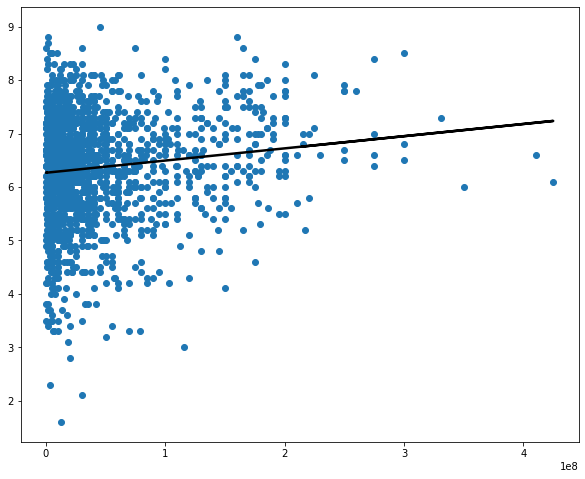

In [34]:
#scatter plot of budget(x) rating(y)
fig,ax = plt.subplots(figsize=(10,8))
x = movie_rating_budget_df["production_budget"]
y = movie_rating_budget_df["averagerating"]
ax.scatter(x,y)
#regression
m, b = np.polyfit(x,y, deg=1)
dist = np.linspace
ax.plot(x, m*x+b, color="k", lw=2.5);

#R^2 correlation metric
R2 = r2_score(x,m*x+b)
print(R2)